## Importing necessary libraries

In [39]:
import nltk

# Cleaning the texts
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
wordnet = WordNetLemmatizer()

from sklearn.linear_model import LogisticRegression

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score,accuracy_score
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report,f1_score

## Data Preparation Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

## Reading the dataset:

In [2]:
sdata=pd.read_csv('smsspamcollection/SMSSpamCollection',sep='\t',names=["label","message"])

In [3]:
sdata.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Preprocessing

In [4]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [5]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

In [6]:
def preprocessing(data):
    text = remove_emoji(data)
    text = remove_special_characters(text)
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [wordnet.lemmatize(text) for text in text if text not in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text;

In [7]:
sdata['message'] = sdata['message'].apply(lambda x:preprocessing(x))

In [8]:
sdata.head()

,label,message
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun say early hor u c already say
4,ham,nah dont think go usf life around though


## Label Encoding

In [13]:
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'Label'. 
sdata['label']= label_encoder.fit_transform(sdata['label']) 

In [14]:
sdata.head()

,label,message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say early hor u c already say
4,0,nah dont think go usf life around though


In [15]:
sdata['label'].unique()

array([0, 1])

In [45]:
pd.DataFrame(sdata['label'].value_counts(normalize=True).mul(100).round(0).astype(str) + '%')

,label
0,87.0%
1,13.0%


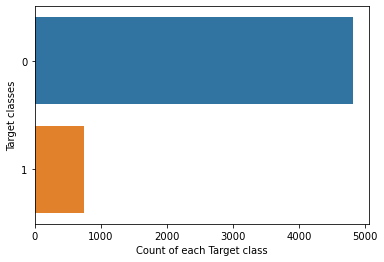

In [46]:
sns.countplot(y=sdata.label ,data=sdata)
plt.xlabel("Count of each Target class")
plt.ylabel("Target classes")
plt.show()

## Creating the Bag of Words model

In [16]:
x = sdata['message']
y = sdata['label']

In [19]:
cv = CountVectorizer()
bow = cv.fit_transform(x);

In [23]:
bow.shape

(5572, 8882)

## Model Building:

In [81]:
def wrong_prediction(conf):
    return conf[0][1] + conf[1][0]

In [103]:
def model_fit(alg,train_X,train_Y):
    x_train,x_test,y_train,y_test = train_test_split(train_X, train_Y, test_size=0.3, random_state=1)
    #Fit the algorithm on the data
    alg.fit(x_train,y_train)
    
    categories = ['ham', 'spam']
    labels = ['True Neg','False Pos','False Neg','True Pos']
    ### Predict training set:
    dtrain_predictions  = alg.predict(x_train);
    ## dtrain_predictions = np.where(dtrain_predictions[:,1]>THRESHOLD_VALUE,1,0)
    train_accuracy=accuracy_score(y_train,dtrain_predictions)
    print(" Train Prediction  Accuracy :",train_accuracy)
    print(classification_report(y_train,dtrain_predictions))
    cf_matrix = confusion_matrix(y_train, dtrain_predictions)
    make_confusion_matrix(cf_matrix, group_names=labels, categories=categories, cmap='Blues', title='Train Prediction')
    print("wrong_prediction : ",wrong_prediction(cf_matrix))
    print("==============================================================")
    
    ### Predict test set:
    dtest_predictions = alg.predict(x_test)
    ## dtest_predictions = np.where(dtest_predictions[:,1]>THRESHOLD_VALUE,1,0)
    test_accuracy=accuracy_score(y_test,dtest_predictions)
    print(" Test Prediction Accuracy :",test_accuracy)
    print(classification_report(y_test,dtest_predictions))
    cf_matrix = confusion_matrix(y_test, dtest_predictions)
    make_confusion_matrix(cf_matrix, group_names=labels, categories=categories, cmap='Blues', title='Test Prediction')
    print("wrong_prediction : ",wrong_prediction(cf_matrix))

## Logistic Regression

 Train Prediction  Accuracy : 0.9946153846153846
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3383
           1       1.00      0.96      0.98       517

    accuracy                           0.99      3900
   macro avg       1.00      0.98      0.99      3900
weighted avg       0.99      0.99      0.99      3900

wrong_prediction :  21
 Test Prediction Accuracy : 0.9772727272727273
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1442
           1       0.99      0.84      0.91       230

    accuracy                           0.98      1672
   macro avg       0.98      0.92      0.95      1672
weighted avg       0.98      0.98      0.98      1672

wrong_prediction :  38


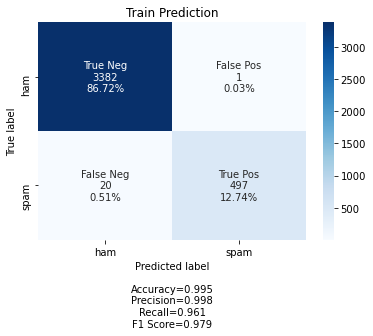

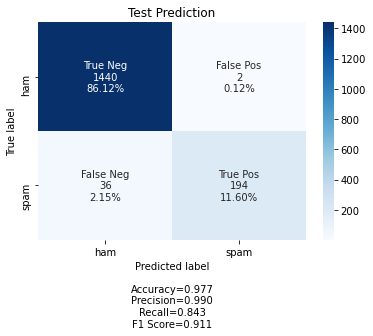

In [104]:
logistic=LogisticRegression()
model_fit(logistic,bow, y)